In [1]:
from pynq import Overlay
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.bit")
bs.download()

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [2]:
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.so')
mem_manager = Xlnk()

import pynq_cv.overlays.xv2Filter2DDilate as xv2
import numpy as np
import cv2
import time

In [3]:
img = cv2.imread('/home/xilinx/jupyter_notebooks/eeve.jpeg')
imgY = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

print("Size of imgY is ",imgY.shape);
height, width, channels = img.shape

Size of imgY is  (497, 701)


In [27]:
kernel_g = {
        'average blur': np.array([
            [1.0, 1.0, 1.0],
            [1.0, 1.0, 1.0],
            [1.0, 1.0, 1.0]],np.float32)/9,
        'gaussian blur': np.array([
            [1.0, 2.0, 1.0],
            [2.0, 4.0, 2.0],
            [1.0, 2.0, 1.0]],np.float32)/16,
        'sobel ver': np.array([
            [1.0,0.0,-1.0],
            [2.0,0.0,-2.0],
            [1.0,0.0,-1.0]],np.float32),
        'sobel hor': np.array([
            [1.0,2.0,1.0],
            [0.0,0.0,0.0],
            [-1.0,-2.0,-1.0]],np.float32),
        'laplacian': np.array([
            [0.0, 1.0, 0],
            [1.0, -4, 1.0],
            [0, 1.0, 0.0]],np.float32),
        'sharpen': np.array([
            [-1,-1, -1],
            [-1, 9, -1],
            [-1, -1, -1]],np.float32),
        'sharpen1': np.array([
            [0,-1,0],
            [-1, 5, -1],
            [0, -1, 0]],np.float32),
}

kernel = kernel_g.get('sharpen1')

numberOfIterations=50

dstSW = np.ones((height,width),np.uint8);

xFimgY  = mem_manager.cma_array((height,width),np.uint8) #allocated physically contiguous numpy array 
xFimgY[:] = imgY[:] # copy source data

xFdst  = mem_manager.cma_array((height,width),np.uint8) #allocated physically contiguous numpy array

In [28]:
startSW=time.time()
for i in range(numberOfIterations):
    cv2.filter2D(imgY,-1,kernel,dst=dstSW,borderType=cv2.BORDER_CONSTANT) #filter2D on ARM
stopSW=time.time()
print("Start SW loop = ", (stopSW - startSW))
print("SW frames per second: ", ((numberOfIterations) / (stopSW - startSW)))

Start SW loop =  1.3562655448913574
SW frames per second:  36.865936901763


In [29]:
startPL=time.time()
for i in range(numberOfIterations):
    xv2.filter2D(xFimgY,-1,kernel,dst=xFdst,borderType=cv2.BORDER_CONSTANT) #filter2D offloaded to PL, working on physically continuous numpy arrays
stopPL=time.time()
print("Start HW loop = ", (stopPL - startPL))
print("PL frames per second: ", ((numberOfIterations) / (stopPL - startPL)))

Start HW loop =  0.1840348243713379
PL frames per second:  271.68771003422734


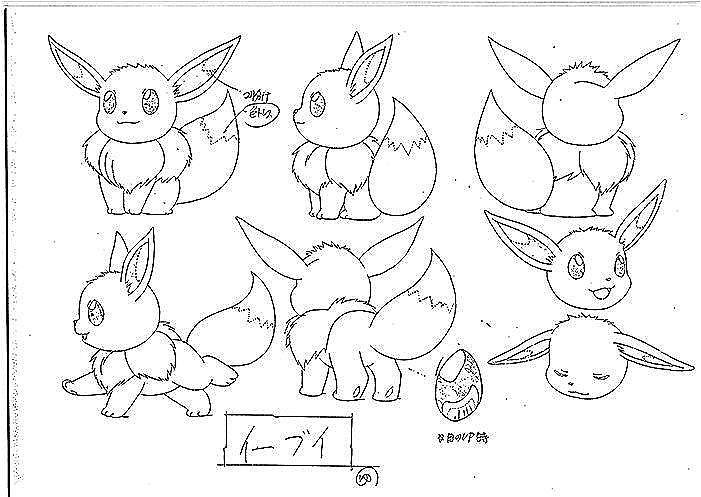

In [30]:
import PIL.Image
image = PIL.Image.fromarray(dstSW)
image

In [31]:
xFdst

PynqBuffer([[0, 0, 0, ..., 0, 0, 0],
            [0, 0, 0, ..., 0, 0, 0],
            [0, 0, 0, ..., 0, 0, 0],
            ...,
            [0, 0, 0, ..., 0, 0, 0],
            [0, 0, 0, ..., 0, 0, 0],
            [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [32]:
dstSW

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 219, 209, ..., 155, 149, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 245, 255, ..., 255, 255, 255],
       [255, 243, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [26]:
imgY

array([[235, 239, 228, ..., 210, 207, 202],
       [221, 233, 231, ..., 203, 201, 198],
       [255, 255, 252, ..., 246, 248, 250],
       ...,
       [255, 252, 255, ..., 255, 255, 255],
       [255, 252, 255, ..., 255, 255, 255],
       [254, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [33]:
kernel

array([[ 0., -1.,  0.],
       [-1.,  5., -1.],
       [ 0., -1.,  0.]], dtype=float32)

In [34]:
print(len(imgY))
print(len(dstSW))
print(len(xFdst))

497
497
497
